### Features vs. TSS neighborhoods
*Purpose*: investigate the number of features around up/down/nonsig genes for dNipbl 24h. Uses histograms

Also includes option to drop tss-proximal or gene-body overlapping features before computing histograms.

In [1]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bbi
from gffutils.helpers import asinterval
from gtfparse import read_gtf
import bioframe as bf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import bioframe
import filter_gene_functions as flt
from plotting_heatmap_functions import format_ticks

save_plots = False
DE_possibilities = ['down', 'up', 'nonsig']
de_color_dict ={ "up": 'tab:red', 
                 "down": 'tab:blue', 
                 "nonsig": 'tab:gray'}

In [2]:
chip_dir = ('/project/fudenber_735/collaborations/karissa_2022/'+
            '2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/')
bed_dict = {
    'H3K27Ac':chip_dir+'H3K27ac_EA92-97_peaks.xls.bed',
    'CTCF':   chip_dir+'CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed',
    'Nipbl':   chip_dir+'Nipbl_112.175.197.114.177.196_peaks.xls.bed',
    'Rad21':  chip_dir+'RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed'
}

dataset_folder = '/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/Published_datasets/'
chen_s1 = 'Enhancers_Chen2012_S1_remapped_mm10.bed'
whythe_super = 'Super-enhancers_mESCs_(OSN-MED1)_Wythe-Cell-2023_mm10-lifetover.bed'
enhancer_dict = {'enh_chen_s1' : dataset_folder+chen_s1,
                 'enh_wythe_super' : dataset_folder+whythe_super}
bed_dict = {**bed_dict, **enhancer_dict}



In [3]:
### create df with intervals & expression data
tss_df = flt.load_tss_df()
tss_df = flt.label_DE_status(tss_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


In [4]:
### merging in gene body information
# todo: potentially re-factor as part of gtf reader
gene_bodies = pd.read_csv(
    "/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/gencode.vM23.primary_assembly.annotation.gtf",
    sep='\t', comment='#', names=[
    'chrom','db','type','start','end','score','strand','score2','metadata'])
gene_id = gene_bodies['metadata'].str.split('";',expand=True)[0].str.replace ('gene_id "','')                      
gene_bodies['gene_id'] = gene_id
gene_bodies.drop_duplicates('gene_id', inplace=True)

tss_df = tss_df.merge(gene_bodies[['chrom','start','end','strand','gene_id']],
                how='left', on='gene_id', suffixes=['','_gene'])

In [6]:
tss_df.shape

(19349, 17)

In [7]:
gene_bodies.shape

(55421, 10)

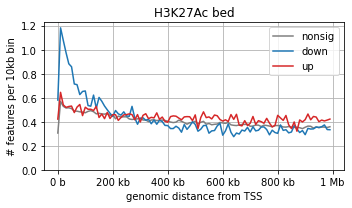

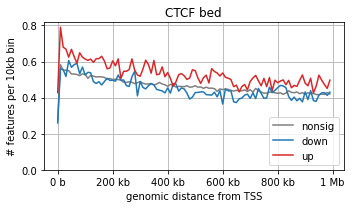

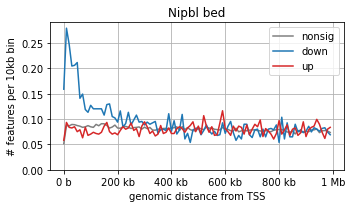

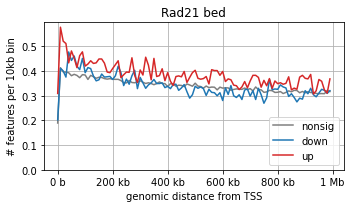

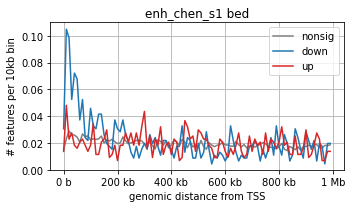

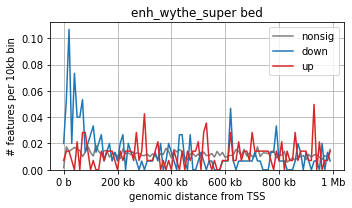

In [8]:
# plot of the number of elements
# in a bed file around each TSS 
# (normalzied by the number of genes in a given category)

window_size = int( 1e6)
mask_tss_proximal = True
tss_window_size = int(5e3)
mask_gene_bodies = False
extend_gene_bp = int(1e3)
if mask_tss_proximal and mask_gene_bodies:
    raise ValueError("choose to mask tss proximal or gene bodies")

save_plots =False
    
bins = np.linspace(0, window_size, 101)
figsize = (5,3)

for bed_name, bed_path in bed_dict.items():
    
    if not 'enh' in bed_name:
        feature_df = bioframe.read_table(bed_path, schema='bed')
    else:
        feature_df = bioframe.read_table(bed_path, schema='bed3', header=1)
    
    plt.figure(figsize=figsize)
    
    if mask_tss_proximal:
        feature_df  = flt.mask_tss_proximal_features( feature_df, tss_df, window_size=tss_window_size)
    if mask_gene_bodies:
        feature_df  = flt.mask_gene_body_features( feature_df, tss_df, extend_gene_bp = extend_gene_bp)
        
    tss_vs_feature_df = flt.extract_features_around_TSS(tss_df, feature_df, window_size=window_size)

    for DE_status in ['nonsig', 'down', 'up']:
        de_vs_features = tss_vs_feature_df.iloc[ tss_vs_feature_df['DE_status'].values==DE_status].copy()
        de_vs_features.dropna(subset=[ 'dist'], inplace=True)
        num_genes_in_category = de_vs_features['gene_id'].unique().shape[0] 

        a,b = np.histogram( 
                de_vs_features['dist'],
                bins=bins);

        plt.plot( bins[:-1], 
                  a/num_genes_in_category,
                  label=DE_status, 
                  color = de_color_dict[DE_status])
    ax = plt.gca()
    format_ticks(ax)
    plt.ylabel(f'# features per {int( (bins[1]-bins[0])/1e3)}kb bin')
    plt.xlabel('genomic distance from TSS')
    plt.title(bed_name + ' bed', fontsize=12)
    plt.legend()
    plt.grid()
    plt.ylim([0, ax.get_ylim()[1]] )
    plt.tight_layout()
    if save_plots: 
        plt.savefig(f'./figs/{bed_name}_features_per_10kb-bin.png',
                   bbox_inches='tight')
    plt.show()

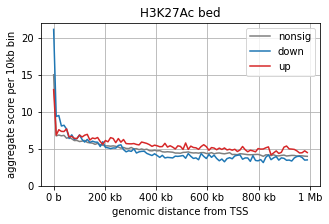

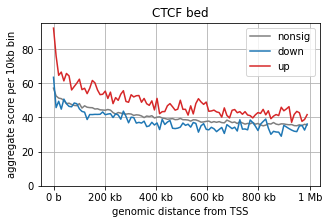

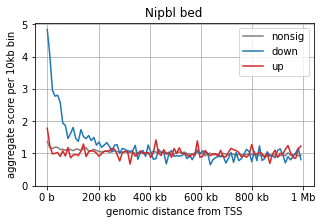

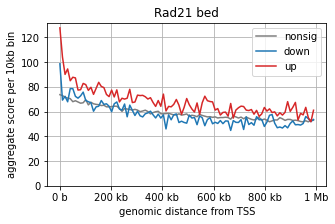

In [9]:
# plot of the number of elements, weighted by their score
# in a bed file around each TSS 
# (normalzied by the number of genes in a given category)

window_size = int( 1e6)
bins = np.linspace(0, window_size, 100)

for bed_name, bed_path in bed_dict.items():
    
    if not 'enh' in bed_name:
        feature_df = bioframe.read_table(bed_path, schema='bed')
    else:
        continue
    
    if not 'score' in feature_df.keys():
        raise KeyError("need to have a bed file with score column for weighted histogram")
    
    plt.figure(figsize=figsize)
    
    tss_vs_feature_df = flt.extract_features_around_TSS(tss_df, feature_df, window_size=window_size)

    for DE_status in ['nonsig', 'down', 'up']:
        de_vs_features = tss_vs_feature_df.iloc[ tss_vs_feature_df['DE_status'].values==DE_status].copy()
        de_vs_features.dropna(subset=[ 'dist'], inplace=True)
        num_genes_in_category = de_vs_features['gene_id'].unique().shape[0] 

        a,b = np.histogram( 
                de_vs_features['dist'],
                weights=de_vs_features['score_'],
                bins=bins);

        plt.plot( bins[:-1], 
                  a/num_genes_in_category,
                  label=DE_status, 
                  color = de_color_dict[DE_status])
    ax = plt.gca()
    format_ticks(ax)
    plt.ylabel('aggregate score per 10kb bin')
    plt.xlabel('genomic distance from TSS')
    plt.title(bed_name + ' bed', fontsize=12)
    plt.legend()
    plt.grid()
    
    plt.ylim([0, ax.get_ylim()[1]] )
    if save_plots: plt.savefig(bed_name+'_score-weighted_features_per_bin.png')
    plt.show()

In [10]:
bonev_cooler_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
feature_dir = '/'.join(bonev_cooler_file.split('/')[:-1])+'/features/'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')
insulation_boundaries = insulation_table.query('is_boundary_200000 == True')

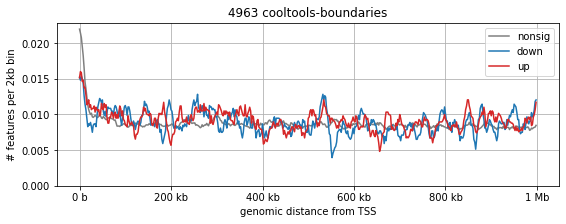

In [13]:
# plot of the number of boundaries around each TSS 
import cooltools
from cooltools.lib.numutils import smooth

window_size = int( 1e6)
#bins = np.linspace(0, window_size, 101)
bins = np.linspace(0, window_size, 501)
figsize = (9,3)

#for bed_name, bed_path in bed_dict.items():
bed_name = 'cooltools-boundaries'
feature_df = insulation_boundaries

plt.figure(figsize=figsize)

tss_vs_feature_df = flt.extract_features_around_TSS(tss_df, feature_df, window_size=window_size)

for DE_status in ['nonsig', 'down', 'up']:
    de_vs_features = tss_vs_feature_df.iloc[ tss_vs_feature_df['DE_status'].values==DE_status].copy()
    de_vs_features.dropna(subset=[ 'dist'], inplace=True)
    num_genes_in_category = de_vs_features['gene_id'].unique().shape[0] 

    a,b = np.histogram( 
            de_vs_features['dist'],
            bins=bins);

    plt.plot( bins[:-1], 
              smooth(a/num_genes_in_category,7),
              label=DE_status, 
              color = de_color_dict[DE_status])
ax = plt.gca()
format_ticks(ax)
plt.ylabel(f'# features per {int( (bins[1]-bins[0])/1e3)}kb bin')
plt.xlabel('genomic distance from TSS')
plt.title(f"{len(feature_df)} {bed_name}" , fontsize=12)
plt.legend()
plt.grid()
plt.ylim([0, ax.get_ylim()[1]] )
if save_plots: 
    plt.savefig(f'./figs/{bed_name}_features_per_10kb-bin.png')
plt.show()

In [14]:
df_mustache = pd.read_csv(feature_dir+'mustache_HiC_ES.mm10.mapq_30.10000.tsv', sep='\t')
df_mustache.rename(columns={'BIN1_CHR':'chrom1','BIN1_START':'start1','BIN1_END':'end1',
                            'BIN2_CHROMOSOME':'chrom2','BIN2_START':'start2','BIN2_END':'end2'
                            },inplace=True)
df_mustache = df_mustache.iloc[(df_mustache['FDR'].values < 0.025)]

df_mustache_anchors = pd.concat(
    [df_mustache[['chrom1','start1','end1']],
    df_mustache[['chrom2','start2','end2']].copy().rename(
        columns={'chrom2':'chrom1','start2':'start1','end2':'end1'}) ],ignore_index=True,axis=0)

df_mustache_anchors = df_mustache_anchors.drop_duplicates(['chrom1','start1','end1']).copy()
df_mustache_anchors.rename(columns={'chrom1':'chrom','start1':'start','end1':'end'}, inplace=True)

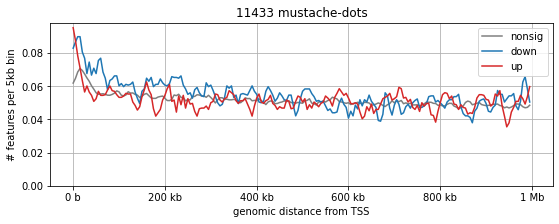

In [15]:
# plot of the number of elements
# in a bed file around each TSS 
# (normalzied by the number of genes in a given category)

window_size = int( 1e6)
#bins = np.linspace(0, window_size, 101)
bins = np.linspace(0, window_size, 201)
figsize = (9,3)

#for bed_name, bed_path in bed_dict.items():
bed_name = 'mustache-dots'
feature_df = df_mustache_anchors

plt.figure(figsize=figsize)

tss_vs_feature_df = flt.extract_features_around_TSS(tss_df, feature_df, window_size=window_size)

for DE_status in ['nonsig', 'down', 'up']:
    de_vs_features = tss_vs_feature_df.iloc[ tss_vs_feature_df['DE_status'].values==DE_status].copy()
    de_vs_features.dropna(subset=[ 'dist'], inplace=True)
    num_genes_in_category = de_vs_features['gene_id'].unique().shape[0] 

    a,b = np.histogram( 
            de_vs_features['dist'],
            bins=bins);

    plt.plot( bins[:-1], 
              smooth(a/num_genes_in_category,3),
              label=DE_status, 
              color = de_color_dict[DE_status])
ax = plt.gca()
format_ticks(ax)
plt.ylabel(f'# features per {int( (bins[1]-bins[0])/1e3)}kb bin')
plt.xlabel('genomic distance from TSS')
plt.title(f"{len(feature_df)} {bed_name}" , fontsize=12)
plt.legend()
plt.grid()
plt.ylim([0, ax.get_ylim()[1]] )
if save_plots: 
    plt.savefig(f'./figs/{bed_name}_features_per_10kb-bin.png')
plt.show()